In [1]:
# Here we load in a bunch of useful code, but nothing to worry about now.  We'll use them later. 
# It's the norm to load most at the start for clarity.

# For (almost) all things file related.
import sys

# For grabbing a bunch of files.
import glob  

# Making plots.
import pylab           as     pl

# Remember Excel?  Probably not.  In any case, this is the silicon valley version.
import pandas          as     pd

# You won't get anywhere in science without it.
import numpy           as     np

# Plots, again.
from   matplotlib      import pyplot as plt

# We'll introduce this later.
from   scipy           import stats

# A few generally useful things for working with data in Astronomy. 
from   astropy.table   import Table, join, vstack

# Data finder.
from   pkg_resources   import resource_filename

In [2]:
# For our friends running on Google Colab - remember to 
# mount your drive for all notebooks other than Colab.ipynb
# 
# Safely ignore otherwise!
sys.path.append('/content/drive/MyDrive/desihigh/')

In [3]:
# Prettier plots
from   tools        import pubplot

# If you know the position of a DESI galaxy, let's you create a photo of it!
from   tools.legacy import cutout

# *Dark Energy Spectroscopic Instrument (DESI)*

Today, we continue the legacy of [Slipher](https://en.wikipedia.org/wiki/Vesto_Slipher), [Hubble](https://en.wikipedia.org/wiki/Edwin_Hubble), [Vera Rubin](https://en.wikipedia.org/wiki/Vera_Rubin) et al. with the DESI survey of *30 Million* galaxies.  That's a lot more than Hubble's original 24! 

![title](desihigh/images/kittpeak.jpg)

<p style='text-align: right;'> Photo Credit: P. Marenfeld, NOAO/AURA/NSF </p>

To get this many galaxies, we need a telescope big enough to observe very faint galaxies.  With a 4m diameter mirror,  the Mayall Telescope at Kitt Peak is just right:

![title](desihigh/images/desi_mayall.jpg)

As Hubble once did, we also need observers to run the telescope for us.  Within DESI, everyone gets a turn at this (whether you're an expert or not!).  Here's [Satya](https://satyagontcho.space/) in the control room, ready for a night of observing.

![alt](desihigh/images/satya.jpg)

Let's first hear from Satya on her experience up on the Kitt Peak mountain in Arizona:

*Typically, the night starts a few hours before sunset. The observers will go up to the telescope and zoom with a handful of DESI collaborators in the afternoon in order to decide on the observing plan for the night. Indeed, depending on the weather, how far along we are in successfully observing all the galaxies and quasars on our list, we need to decide what we should observe in priority that night. Once the plan is made, we all leave the telescope to grab dinner, catch one last beautiful view before sunset from the mountain top, and go back to the telescope to start our work. While the sun sets, we do tests to ensure the telescope is properly set up. Right as the sky gets dark enough, we open the dome and we are in business.* 

*During the night, the role of an observer is to monitor the efficiency of the intrument that collects the light from distant galaxies and quasars, monitor the weather and as a result use their judgement to adapt the night plan. On the picture below, you get a tiny glimpse of the myriad of screens that one needs to keep their eye on to make sure everything is functioning as it should. This goes on until the sun rises the next morning. Observing is an extremely gratifying activity because it gives us a chance to measure all the steps and the magnitude of work it takes to get quality data. Imagine this: we are smoothly moving a telescope that weighs several tons, adjusting the position of optical fibers the thickness of 1/3 of a hair to fall exactly on a galaxy or a quasar in order to collect their photons that travelled billions of light years to reach us. Sometimes, working with catalog of data for long enough, we foreget how incredibly privileged and special our work is. We get to build state-of-the-art large  instruments that collect the tiny and rare photons from distant celestial objects that we will in turn use to play detectives in order to piece together the history of our universe. How cool.*

This might be you one day! Straight off the telescope, our data looks pretty unrecognizable:

![title](desihigh/images/spectra2D.png)

Here you're seeing the light from 500 optical fibers (each collecting the light of one galaxy) packed onto a CCD. The horizontal arches correspond to a given wavelength, with the bright arches corresponding to bright sky lines - a complete nuisance!  

The apparently random tracks are cosmic rays - detections of high energy particles generated within the atmosphere.  

We need to carefully calibrate and clean these images to retrieve the galaxy light we really care about.  Let's assume some smart people have done this for us, and look at the cleaned images of the light of a few DESI galaxies.      

We'll also look to add some markers that indicate the strong lines from Hydrogen (that we learnt about previously) in a few DESI Quasar spectra.

In [4]:
def Rydberg(n, m):
    # Vacuum wavelengths of Hydrogen [nanometres], see the Intro.
    result = 1.096e-2 * (1. / n / n - 1. / m / m)
    return 1. / result

In [5]:
# Hydrogen Lyman-alpha line.
Lya        = 10. * Rydberg(1, 2)

# The Hydrogen Balmer series.
Balmers    = 10. * np.array([Rydberg(2, m) for m in np.arange(6, 3, -1)])
Balmers

array([4105.83941606, 4344.80361488, 4866.18004866])

Now we're going to select a DESI galaxy type (we think of galaxies as difference _tracers_ of dark matter).  We'll start off with QSO, which will be explained later.  At the end of the notebook, you'll get the chance to select from the others.

For your viewing pleasure, you have any of

- MWS:  The Milky Way Survey, a subset of targets trying to catch stars and [white dwarves](www.en.wikipedia.org/wiki/White_dwarf).   
- BGS:  The Bright Galaxy Survey, some of the brightest, and prettiest galaxies in the DESI survey. 
- LRG:  Luminous Red Galaxy, very red, very luminous (astronomers aren't usually that creative).  [Approx. 6Gyr old and weighing in with $10^{11}$ stars](https://academic.oup.com/mnras/article/377/2/787/1038423).  
- ELG:  Emission line galaxy, with their own notebook: DesigningDESI.ipynb.

In [6]:
# Replace ['qso'] with any of ['mws'], ['bgs'], ['lrg'], ['elg'], ['qso'] here. 
tracers     = ['qso'] 

Ok, first we need to load the data we need.  The packages above are very useful for this.  Try and break it apart 
and see what's in there!

In [7]:
# Here we create empty tables that we will fill with data on the redshift of galaxies, and their spectra.
redshifts   = Table()
spectra     = Table()

# DESI observes a "tile" of 5000 galaxies at a time.  We need to know the ID number for the tile corresponding to the targets we want.
tiles       = {'mws': 66003, 'bgs': 66003, 'elg': 67230, 'lrg': 68002, 'qso': 68002}

# Find all files in the student_andes directory that begin with e.g. zbest-.
andes       = resource_filename('desihigh', 'student_andes/')

rfiles      = glob.glob(andes + '/zbest-*')
sfiles      = glob.glob(andes + '/coadd-*')

for tracer in tracers:
  # Create the filename for this tracer and tile.
  rfile     = andes + '/zbest-{}-{}-20200315.fits'.format(tracer, tiles[tracer])    
  
  # Load the redshift information for this tile and tracer.  
  redshifts = vstack((redshifts, Table.read(rfile)))

  # Same thing, but for their spectra.
  sfile     = andes + '/coadd-{}-{}-20200315.fits'.format(tracer, tiles[tracer]) 
  spectra   = vstack((spectra, Table.read(sfile)))
    
print('Number of {} galaxies available: {:d}'.format(tracers[0], len(redshifts)))

Number of qso galaxies available: 5


Remember, in python everything is an object, so you have lots of ways to ask any given thing what it can do. Try writing 'rfiles?', 'print(rfiles)', 'rfiles.TAB' in a new cell to see what this object can do.  TAB means you finish with the TAB key, this will bring up a box telling you the available methods for the object - things you can ask for it to do.  E.g. rfiles.append, to which you can ask: 'rfiles.append?' and so on.  You can try the same thing with the redshifts Table, which will have many more options!  

Let's see what we got on their redshifts.  We'll have five rows, one for each galaxy.  Their position on the sky, brightness at various wavelengths, type of galaxy, and their ID number.

In [8]:
redshifts

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,SPECTYPE,SUBTYPE,DELTACHI2,FLUX_G,FLUX_R,FLUX_Z,CMX_TARGET,TARGET_RA,TARGET_DEC
int64,float64,float64,float64,float64,int64,bytes6,bytes20,float64,float32,float32,float32,int64,float64,float64
35185923939371431,11016.900862008333,0.0003265550498036014 .. 0.0,2.1337630727260914,0.00013205139345019885,0,QSO,,5860.220424488187,2.5460253,3.1282206,6.450677,54043195528452129,201.80667962268615,6.729774250640312
35185923947758947,21945.633102953434,0.0004955295761302617 .. 0.0,3.0785927158659323,0.00016631319919794678,0,QSO,,11827.31509694457,8.932832,12.4369755,12.0257435,36028797018968097,202.25254229517117,6.691848069124624
35185935939273277,15432.242701277137,0.0004224146530610961 .. 0.0,2.3164113479186756,0.00041214508701321547,0,QSO,,6832.880943790078,4.761269,5.188889,10.378841,54043195528452129,201.75151932056085,7.151470635471182
35185935939275605,13586.427393898368,0.0012699971991643312 .. 0.0,1.14930669628165,0.00011914618492830202,0,QSO,,5283.966160789132,12.528511,15.657297,14.882251,36028797018968097,201.86545000766887,7.2589693081721665
35185935947662300,10059.80414417386,0.0015397448797003833 .. 0.0,1.1643281636101708,7.44466154972391e-05,0,QSO,,7105.9863316342235,10.1635685,11.986815,12.02004,36028797018968064,202.33753792617628,7.177549027087691


Now, we'll use the spectra Table to plot the galaxy light!

Text(0.5, 0.91, 'QSO Tracers')

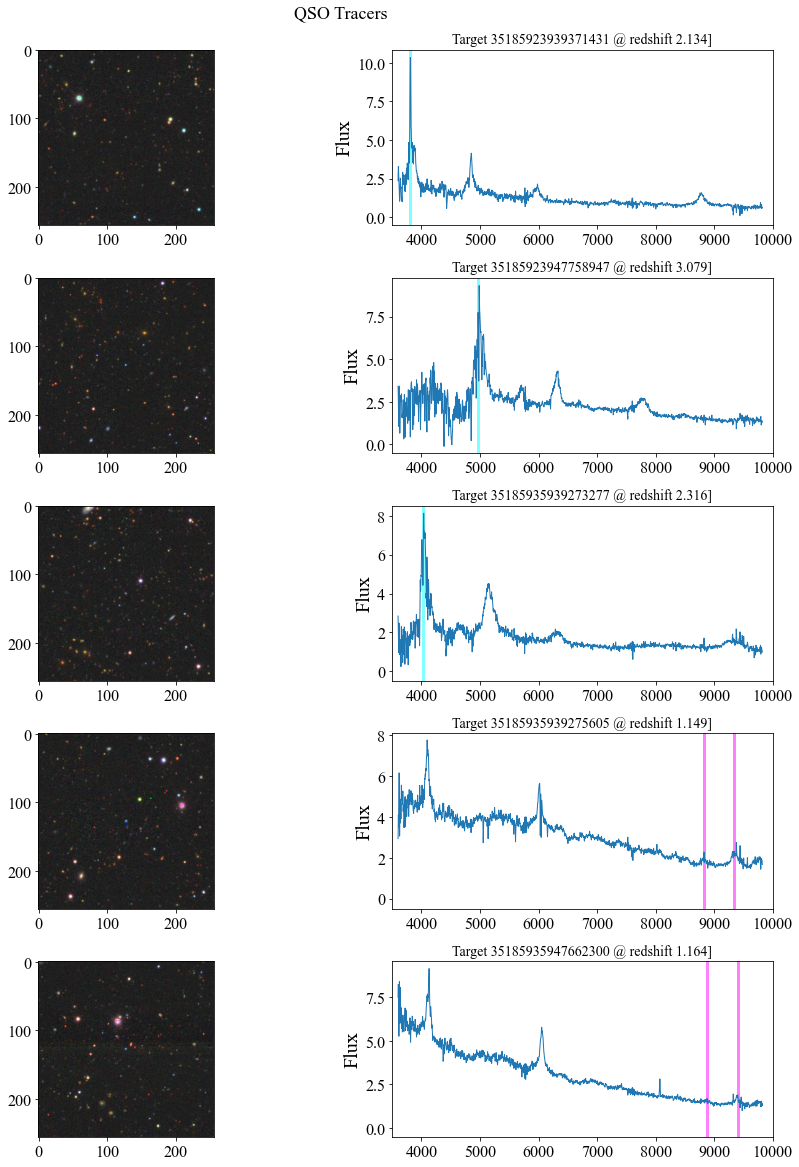

In [19]:
ngal       = 5

# Make the plots.
fig, axes  = plt.subplots(ngal, 2, figsize=(15., 4.0 * ngal))

for i, tid in enumerate(redshifts['TARGETID'][:ngal]):
  redshift = redshifts['Z'][i]

  # This plots a vertical line.  Here, to show lyman-alpha. 
  axes[i,1].axvline((1. + redshift) * Lya, c='cyan', alpha=0.5)

  # Plot the Balmer lines. 
  for balmer in Balmers:
    axes[i,1].axvline((1. + redshift) * balmer, c='magenta', alpha=0.5)      
    
  # Finally, plot the galaxy spectra!  
  axes[i,1].plot(spectra['WAVELENGTH'], spectra['TARGET{:d}'.format(tid)], lw=1)
  
  # Add a tile.
  axes[i,1].set_title('Target {} @ redshift {:.3f}]'.format(tid, redshift), fontsize=14)

  # Set the axis limits. 
  axes[i,1].set_xlim(3.5e3, 1.e4)
  axes[i,1].set_ylim(bottom=-0.5)

  axes[i,1].set_ylabel('Flux')

  # Add a photo of each galaxy.
  url = cutout(axes[i,0], redshifts['TARGET_RA'][i], redshifts['TARGET_DEC'][i])

fig.subplots_adjust(hspace=0.3)

fig.suptitle('{} Tracers'.format(tracers[0].upper()), fontsize=18, y=0.91)

Notice how the Hydrogen lines we see are very broad.  This is because the Hydrogen is rapidly moving within this type of galaxy, known as Quasar or "Quasi-stellar object".  They are very distant, but still bright, due to matter accreting onto a large blackhole in their center!  See https://en.wikipedia.org/wiki/Quasar for more details.

Now it's your turn, try try changing tracers=['qso'] to tracers=['lrg'] in cell [9] above and rerun the cells above to remake these plots for a different type of galaxy.  Remember, you need shift-return to evaluate a cell.  What do you notice is different about the different galaxy tracers and their colors? 

Now you're an expert, can you figure out what lines other than Hydrogen are present here (and plot them)?
You might try the list [here](http://classic.sdss.org/dr6/algorithms/linestable.html) to start.  

The Paschen series is a good one!